In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing 
import torch 
from torch import nn
from torch.nn import functional as F
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

## Question 2.0: Data preparation 

In [2]:
# load train and test data 
data_train = np.load("adult/adult_train.npz")
train_x = data_train['x']
train_y = data_train['y']
data_test = np.load("adult/adult_test.npz")
test_x = data_test['x']
test_y = data_test['y']

In [3]:
# load data headers
headers = pd.read_csv("adult/adult_headers.txt",header=None)
headers = np.array(headers).flatten()

In [4]:
# convert training data array into pandas dataframe 
train_data_pd = pd.DataFrame(data = np.concatenate((train_x, train_y), axis=1), columns = headers).drop(['sex_Female'], axis=1)

# normalize training data of males recoreds 
train_data_pd_males = train_data_pd[train_data_pd['sex_Male'] == 1]
normalized_males = ((train_data_pd_males-train_data_pd_males.mean())/train_data_pd_males.std()).fillna(value=0)
train_males_x = torch.from_numpy(normalized_males.drop(['income'], axis=1).values).float()
train_males_y = torch.from_numpy(train_data_pd_males['income'].values).float().view(-1,1)

# normalize training data of females recoreds 
train_data_pd_females = train_data_pd[train_data_pd['sex_Male'] == 0]
normalized_females=((train_data_pd_females-train_data_pd_females.mean())/train_data_pd_females.std()).fillna(value=0)
train_females_x = torch.from_numpy(normalized_females.drop(['income'], axis=1).values).float()
train_females_y = torch.from_numpy(train_data_pd_females['income'].values).float().view(-1,1)

# concatendate the two records to get the full training set (inputs and targets)
train_x_cat = torch.cat((train_males_x, train_females_x), dim = 0)
train_y_cat = torch.cat((train_males_y, train_females_y), dim = 0)

# shuffle the concatenated training data 
index = torch.randperm(train_x_cat.shape[0])
train_x_cat = train_x_cat[index,:]  
train_y_cat = train_y_cat[index,:]

In [5]:
# convert test data array into pandas dataframe 
test_data_pd = pd.DataFrame(data = np.concatenate((test_x, test_y), axis=1), columns = headers).drop(['sex_Female'], axis=1)


# normalize test data of males recoreds 
test_data_pd_males = test_data_pd[test_data_pd['sex_Male'] == 1]
normalized_males_test=((test_data_pd_males-train_data_pd.mean())/train_data_pd.std()).fillna(value=0)
test_males_x = torch.from_numpy(normalized_males_test.drop(['income'], axis=1).values).float()
test_males_y = torch.from_numpy(test_data_pd_males['income'].values).float().view(-1,1)

# normalize test data of females recoreds 
test_data_pd_females = test_data_pd[test_data_pd['sex_Male'] == 0]
normalized_females_test=((test_data_pd_females-train_data_pd.mean())/train_data_pd.std()).fillna(value=0)
test_females_x = torch.from_numpy(normalized_females_test.drop(['income'], axis=1).values).float()
test_females_y = torch.from_numpy(test_data_pd_females['income'].values).float().view(-1,1)

# concatendate the two records to get the full test set (inputs and targets)
test_x_cat = torch.cat((test_males_x, test_females_x), dim = 0)
test_y_cat = torch.cat((test_males_y, test_females_y), dim = 0)

# shuffle the concatenated test data 
index = torch.randperm(test_x_cat.shape[0])
test_x_cat = test_x_cat[index,:]  
test_y_cat = test_y_cat[index,:]

## Question 2.1.a: predicting income using normalized data 

In [10]:
# define generic binary classifer NN with two hidden layers
class model(nn.Module):
    def __init__(self,input_size,n_hidden):
        super(model, self).__init__()
        self.h1 = nn.Sequential(
        nn.Linear(input_size, n_hidden), # layer 1 
        nn.BatchNorm1d(n_hidden),
        nn.ReLU()
        ) 
        
        self.h2 = nn.Sequential(         
        nn.Linear(n_hidden, n_hidden//2), # layer 2
        nn.BatchNorm1d(n_hidden//2),
        nn.ReLU(),
        )
    
        self.o = nn.Sequential(  
        nn.Linear(n_hidden//2,1)
        )
        
    def forward(self, x):
        x = self.h1(x)
        x = self.h2(x)
        x = self.o(x)
        return x

In [ ]:
#define traing generic training function 
def train(epoch, train_model, input_data, targets, train_optimizer):
    train_model.train()
    for data,target in zip(input_data.split(batch_size),targets.split(batch_size)):
        output = train_model(data)
        loss = F.binary_cross_entropy_with_logits(output,target)
        train_optimizer.zero_grad()
        loss.backward()
        train_optimizer.step()
    if(epoch%5 == 0):
        train_losses.append(loss.item())
        print("[EPOCH]: %i, [LOSS]: %.6f" % (epoch, loss.item()))

In [6]:
#define generic test function that return the following metrics 
# accuracy 
# accuracy per males data
# accuracy per females data 
# rewieghted accuracy 
# Demographic parity 
# avg no of males with preditction of 1
# avg no of females with predictions of 1

def test(test_model, test_x, test_y, test_m_x, test_m_y, test_f_x, test_f_y):
    with torch.no_grad():
        test_model.eval()
        accuracy = accuracy_score(test_y.numpy(), ((test_model(test_x)>0).int()).numpy() )
        accuracy_males = accuracy_score(test_m_y.numpy(), ((test_model(test_m_x)>0).int()).numpy() )
        accuracy_females = accuracy_score(test_f_y.numpy(), ((test_model(test_f_x)>0).int()).numpy() )
        R = 0.5 * (accuracy_males + accuracy_females) 
        no_males = ((test_model(test_m_x)>0).int()).numpy().sum()
        no_females = ((test_model(test_f_x)>0).int()).numpy().sum()
        no_males_avg = no_males/test_m_x.shape[0]
        no_females_avg = no_females/test_f_x.shape[0]
        DP = np.abs((no_males_avg - no_females_avg))
    return accuracy, accuracy_males, accuracy_females, R, DP, no_males_avg, no_females_avg

In [ ]:
# set the training and model parameters for the g_classifer 
batch_size = 4048
input_size = 112
n_hidden = 100
lr = 1e-2
g_classifer = model(input_size,n_hidden)
g_optimizer = torch.optim.Adam(g_classifer.parameters(), lr=lr)
train_losses = []
epoch = 0
num_of_epochs = 100

In [ ]:
for epoch in range(num_of_epochs):
    train(epoch, g_classifer,train_x_cat, train_y_cat, g_optimizer)

In [ ]:
#get the metrics of the accuracy and DP
accuracy, accuracy_males, accuracy_females, r, dp, no_males_avg, no_females_avg = test(g_classifer, test_x_cat, test_y_cat,test_males_x, test_males_y, test_females_x, test_females_y )
print('accuracy = {0}, no_females_avg = {1}, no_males_avg = {2}'.format(accuracy,no_females_avg , no_males_avg))
print('reweighted accuracy', r)
print('demographic parity (DP)', dp)
print('accuracy_males = {0}, accuracy_females = {1}'.format(accuracy_males,accuracy_females))

### Question 2.1.b predicting gender using normalized data

In [ ]:
#prepare training data 
train_x_males_2 = torch.from_numpy(normalized_males.drop(['sex_Male', 'income'], axis=1).values).float()
train_y_males_2 = torch.from_numpy(train_data_pd_males['sex_Male'].values).float().view(-1,1)
train_x_females_2 = torch.from_numpy(normalized_females.drop(['sex_Male', 'income'], axis=1).values).float()
train_y_females_2 = torch.from_numpy(train_data_pd_females['sex_Male'].values).float().view(-1,1)

train_x_cat_2 = torch.cat((train_x_males_2, train_x_females_2), dim = 0)
train_y_cat_2 = torch.cat((train_y_males_2, train_y_females_2), dim = 0)
index = torch.randperm(train_x_cat_2.shape[0])
train_x_cat_2 = train_x_cat_2[index,:]  
train_y_cat_2 = train_y_cat_2[index,:]

In [ ]:
#prepare test data 
test_males_x_2 = torch.from_numpy(normalized_males_test.drop(['sex_Male','income'], axis=1).values).float()
test_males_y_2 = torch.from_numpy(test_data_pd_males['sex_Male'].values).float().view(-1,1)
test_females_x_2 = torch.from_numpy(normalized_females_test.drop(['sex_Male', 'income'], axis=1).values).float()
test_females_y_2 = torch.from_numpy(test_data_pd_females['sex_Male'].values).float().view(-1,1)

test_x_cat_2 = torch.cat((test_males_x_2, test_females_x_2), dim = 0)
test_y_cat_2 = torch.cat((test_males_y_2, test_females_y_2), dim = 0)
#shuffle data
index = torch.randperm(test_x_cat_2.shape[0])
test_x_cat_2 = test_x_cat_2[index,:]  
test_y_cat_2 = test_y_cat_2[index,:]

In [ ]:
h_classifer = model(111,n_hidden)
h_optimizer = torch.optim.Adam(h_classifer.parameters(), lr=lr)
train_losses = []
epoch = 0
num_of_epochs = 30

In [ ]:
for epoch in range(num_of_epochs):
    train(epoch, h_classifer,train_x_cat_2, train_y_cat_2, h_optimizer)

In [ ]:
accuracy, accuracy_males, accuracy_females, r, dp, no_males_avg, no_females_avg = test(h_classifer, test_x_cat_2, test_y_cat_2, test_males_x_2, test_males_y_2, test_females_x_2, test_females_y_2)
print('accuracy = {0}, no_females_avg = {1}, no_males_avg = {2}'.format(accuracy,no_females_avg , no_males_avg))
print('reweighted accuracy', r)
print('demographic parity (DP)', dp)
print('accuracy_males = {0}, accuracy_females = {1}'.format(accuracy_males,accuracy_females))

### Question 2.2.a predicting income using MMD requalrized model

In [7]:
#prepare training data 
train_data_pd_x_3 = ((train_data_pd - train_data_pd.mean())/train_data_pd.std()).fillna(value =0)
train_data_y_3 =  torch.from_numpy(train_data_pd['income'].values).float().view(-1,1)   

train_males_x_3 = torch.from_numpy(train_data_pd_males.drop(['income'], axis=1).values).float()
train_males_y_3 = torch.from_numpy(train_data_pd_males['income'].values).float().view(-1,1)
train_females_x_3 = torch.from_numpy(train_data_pd_females.drop(['income'], axis=1).values).float()
train_females_y_3 = torch.from_numpy(train_data_pd_females['income'].values).float().view(-1,1)

train_data_x_3  = torch.from_numpy(train_data_pd.drop(['income'], axis=1).values).float()
train_data_y_3 =  torch.from_numpy(train_data_pd['income'].values).float().view(-1,1)

In [8]:
#prepare test data 
test_males_x_3 = torch.from_numpy(test_data_pd_males.drop(['income'], axis=1).values).float()
test_males_y_3 = torch.from_numpy(test_data_pd_males['income'].values).float().view(-1,1)
test_females_x_3 = torch.from_numpy(test_data_pd_females.drop(['income'], axis=1).values).float()
test_females_y_3 = torch.from_numpy(test_data_pd_females['income'].values).float().view(-1,1)

test_data_x_3  = torch.from_numpy(test_data_pd.drop(['income'], axis=1).values).float()
test_data_y_3 =  torch.from_numpy(test_data_pd['income'].values).float().view(-1,1)

In [9]:
# define training function that uses mmd loss 
from mmd import MMD_torch
def train_mmd(epoch, train_model, train_in, train_t, train_optimizer, alpha):
    train_model.train()
    for data,target in zip(train_in.split(batch_size),train_t.split(batch_size)):
        output = train_model(data)
        
        train_model.eval()
        representation = train_model.h1(data)
        z = train_model.h2(representation)
        train_model.train()
        
        a = data[:,66]
        mmd_loss = MMD_torch(z, a)
        bce_loss = F.binary_cross_entropy_with_logits(output,target) 
        loss =  bce_loss + alpha *mmd_loss
        train_optimizer.zero_grad()
        loss.backward()
        train_optimizer.step()
    if(epoch%5 == 0):
        train_losses.append(loss.item())
        print("[EPOCH]: %i, [LOSS]: %.6f,  [BCE loss]: %.6f ,[MMD loss]: %.6f" % (epoch, loss.item(), bce_loss , mmd_loss))

In [ ]:
# set the training and model parameters 
batch_size = 512
g_classifier_mmd = model(input_size,n_hidden)
g_optimizer_mmd = torch.optim.Adam(g_classifier_mmd.parameters(), lr=1e-3)
train_losses = []
epoch = 0
num_of_epochs = 30

In [ ]:
for epoch in range(num_of_epochs):
    train_mmd(epoch, g_classifier_mmd, train_data_x_3, train_data_y_3, g_optimizer_mmd, alpha = 0.1)

In [ ]:
# print accuracy and reweighted accuracy 
accuracy, accuracy_males, accuracy_females, r, dp, no_males_avg, no_females_avg = test(g_classifier_mmd, test_data_x_3, test_data_y_3, test_males_x_3, test_males_y_3, test_females_x_3, test_females_y_3 )
print('accuracy = {0}, no_females_avg = {1}, no_males_avg = {2}'.format(accuracy,no_females_avg , no_males_avg))
print('reweighted accuracy', r)
print('demographic parity (DP)', dp)
print('accuracy_males = {0}, accuracy_females = {1}'.format(accuracy_males,accuracy_females))

### Question 2.2.b: predicting gender using MMD requalrized model with representation features 

In [ ]:
# get representations of the training and test data using the mmd-based trained g_classifier  
with torch.no_grad():
    g_classifier_mmd.eval()
    fair_representation_train = g_classifier_mmd.h1(train_data_x_3)
    fair_representation_train = g_classifier_mmd.h2(fair_representation_train)
    fair_representation_test = g_classifier_mmd.h1(test_data_x_3)
    fair_representation_test = g_classifier_mmd.h2(fair_representation_test)
    fair_representation_test_males = g_classifier_mmd.h1(test_males_x_3)
    fair_representation_test_males = g_classifier_mmd.h2(fair_representation_test_males)
    fair_representation_test_females = g_classifier_mmd.h1(test_females_x_3)
    fair_representation_test_females = g_classifier_mmd.h2(fair_representation_test_females)

In [ ]:
# set the training and model parameters 
batch_size = 4048
h_classifier_mmd = model(n_hidden//2 ,n_hidden)
h_optimizer_mmd = torch.optim.Adam(h_classifier_mmd.parameters(), lr=1e-2)
train_losses = []
epoch = 0
num_of_epochs = 100

In [ ]:
for epoch in range(num_of_epochs):
    train(epoch, h_classifier_mmd, fair_representation_train, train_data_y_3, h_optimizer_mmd)

In [ ]:
accuracy, accuracy_males, accuracy_females, r, dp, no_males_avg, no_females_avg  = test(h_classifier_mmd, fair_representation_test, test_data_y_3, fair_representation_test_males, test_males_y_3, fair_representation_test_females, test_females_y_3 )
print('accuracy = {0}, no_females_avg = {1}, no_males_avg = {2}'.format(accuracy,no_females_avg , no_males_avg))
print('reweighted accuracy', r)
print('demographic parity (DP)', dp)
print('accuracy_males = {0}, accuracy_females = {1}'.format(accuracy_males,accuracy_females))

### Question 2.3: alpha Hyperparameter tuning

In [16]:
batch_size = 512
input_size = 112
n_hidden = 100
train_losses = []
lr = 1e-2
accuracy_list = []
r_list = []
dp_list = []
accuracy_m = []
accuracy_f = []
alphas = [0.001,0.005, 0.01, 0.05, 0.1, 0.5, 1, 10]
num_of_epochs = 20 
for alpha in alphas:
    mmd_classifier = model(input_size,n_hidden)
    mmd_optimizer = torch.optim.Adam(mmd_classifier.parameters(), lr=lr)
    for epoch in range(num_of_epochs):
        train_mmd(epoch, mmd_classifier, train_data_x_3, train_data_y_3, mmd_optimizer, alpha = alpha)
    accuracy, accuracy_males, accuracy_females, r, dp, no_males_avg, no_females_avg = test(mmd_classifier, test_data_x_3, test_data_y_3, test_males_x_3, test_males_y_3, test_females_x_3, test_females_y_3)
    print('metrics: ' , accuracy, accuracy_males, accuracy_females, r, dp, no_males_avg, no_females_avg)
    accuracy_list.append(accuracy)
    r_list.append(r)
    dp_list.append(dp)
    accuracy_m.append(accuracy_males)
    accuracy_f.append(accuracy_females)

[EPOCH]: 0, [LOSS]: 0.363493,  [BCE loss]: 0.363409 ,[MMD loss]: 0.084323
[EPOCH]: 5, [LOSS]: 0.303814,  [BCE loss]: 0.303754 ,[MMD loss]: 0.059969
[EPOCH]: 10, [LOSS]: 0.318856,  [BCE loss]: 0.318779 ,[MMD loss]: 0.077605
[EPOCH]: 15, [LOSS]: 0.297849,  [BCE loss]: 0.297768 ,[MMD loss]: 0.080392
metrics:  0.8363122658313371 0.7946593001841621 0.9197565024903155 0.8572079013372388 0.10397176521426292 0.15211786372007366 0.04814609850581074
[EPOCH]: 0, [LOSS]: 0.349503,  [BCE loss]: 0.349183 ,[MMD loss]: 0.064032
[EPOCH]: 5, [LOSS]: 0.300684,  [BCE loss]: 0.300297 ,[MMD loss]: 0.077513
[EPOCH]: 10, [LOSS]: 0.292942,  [BCE loss]: 0.292543 ,[MMD loss]: 0.079880
[EPOCH]: 15, [LOSS]: 0.319027,  [BCE loss]: 0.318618 ,[MMD loss]: 0.081730
metrics:  0.8248264848596524 0.7788213627992634 0.9169894853348091 0.8479054240670363 0.07488241451038063 0.11804788213627992 0.04316546762589928
[EPOCH]: 0, [LOSS]: 0.359902,  [BCE loss]: 0.359208 ,[MMD loss]: 0.069423
[EPOCH]: 5, [LOSS]: 0.322534,  [BCE lo

In [17]:
accuracy_list

[0.8363122658313371,
 0.8248264848596524,
 0.8401818070143111,
 0.7646336220133898,
 0.7879122903998526,
 0.7861924943185308,
 0.7857011240095817,
 0.23659480375898287]

In [27]:
dp_list
0.103
0.074
0.100
0.001
0.02
0.015 
0.015
0.001
    

[0.10397176521426292,
 0.07488241451038063,
 0.10039161191234008,
 0.0010125855966310673,
 0.02839622055012174,
 0.015817452285515406,
 0.015725677001959842,
 0.0005537091788533344]

In [19]:
np.argmax(np.array(dp_list))

0

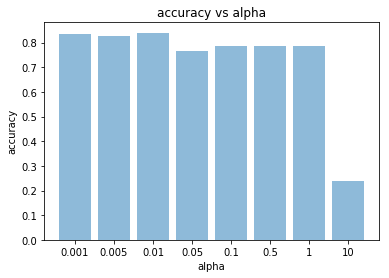

In [22]:
alphas = [0.001,0.005, 0.01, 0.05, 0.1, 0.5, 1, 10]
y_pos = np.arange(len(alphas))

plt.bar(y_pos, accuracy_list, align='center', alpha=0.5)
plt.xticks(y_pos, alphas)
plt.ylabel('accuracy')
plt.xlabel('alpha')
plt.title('accuracy vs alpha')
plt.savefig('accuracy.png')
plt.show()

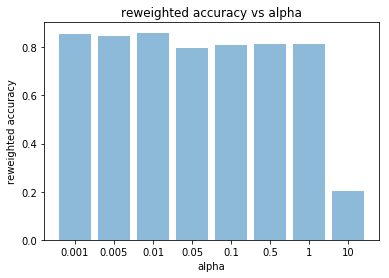

In [23]:
plt.bar(y_pos, r_list, align='center', alpha=0.5)
plt.xticks(y_pos, alphas)
plt.ylabel('reweighted accuracy')
plt.xlabel('alpha')
plt.title('reweighted accuracy vs alpha')
plt.savefig('r.png')
plt.show()

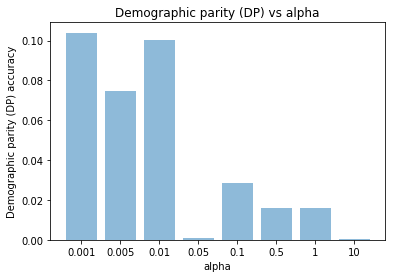

In [24]:
plt.bar(y_pos, dp_list, align='center', alpha=0.5)
plt.xticks(y_pos, alphas)
plt.ylabel('Demographic parity (DP) accuracy')
plt.xlabel('alpha')
plt.title('Demographic parity (DP) vs alpha')
plt.savefig('dp.png')
plt.show()

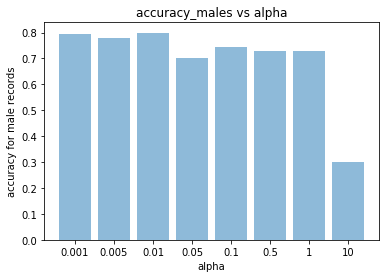

In [25]:
plt.bar(y_pos, accuracy_m, align='center', alpha=0.5)
plt.xticks(y_pos, alphas)
plt.ylabel('accuracy for male records')
plt.xlabel('alpha')
plt.title('accuracy_males vs alpha')
plt.savefig('am.png')
plt.show()

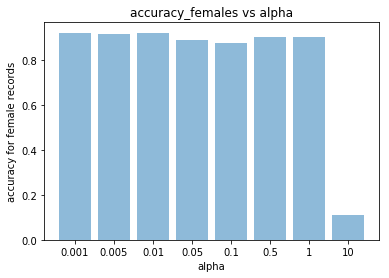

In [26]:
plt.bar(y_pos, accuracy_f, align='center', alpha=0.5)
plt.xticks(y_pos, alphas)
plt.ylabel('accuracy for female records')
plt.xlabel('alpha')
plt.title('accuracy_females vs alpha')
plt.savefig('af.png')
plt.show()